<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Resumen del proceso de optimización

* **Iteración 1: FastText & Embeddings**
    Reemplazo de GloVe por **FastText (300d)**, implementando una carga agnóstica de pesos y congelando la capa de embedding para *transfer learning*.

* **Iteración 2: Monitoreo con WANDB**
    Integración de **Weights & Biases** adaptada a Keras 3 (`WandbMetricsLogger`) y gestión segura de credenciales mediante *Secrets* y variables de entorno.

* **Iteración 3: Optimización de Memoria**
    Migración a `sparse_categorical_crossentropy` para eliminar la codificación *one-hot* en los targets, reduciendo drásticamente el uso de RAM.

* **Iteración 4: Capacidad y Regularización**
    Escalado de la arquitectura a **256 unidades LSTM** e introducción de **Dropout (0.3)** en encoder y decoder para combatir el *overfitting*.

* **Iteración 5: Persistencia e Inferencia**
    Implementación de **EarlyStopping** y **ModelCheckpoint** en Google Drive, junto con una lógica de "hidratación" para reconstruir la inferencia desde el modelo guardado.

* **Iteración 6: DataGenerator (Full Dataset)**
    Desarrollo de un generador de datos (`Sequence`) para entrenar por *batches*, permitiendo el uso del **dataset completo (+118k frases)** sin límites de memoria.

* **Iteración 7: Scaling Definitivo (512 Units)**
    Escalado final de la arquitectura a **512 unidades LSTM** y aumento del **Dropout a 0.4**, maximizando la capacidad del modelo para capturar matices complejos en el dataset completo.

### Análisis de Resultados: Impacto de la Escala y el Volumen de Datos

![Arquitectura del modelo](https://github.com/joseluisdiaz/procesamiento_lenguaje_natural-tp/raw/main/img/desafio4.png)

La gráfica comparativa de experimentos muestra una evolución clara y positiva en el rendimiento del modelo a través de las distintas iteraciones. La línea naranja (**`final_run`**), correspondiente a nuestra arquitectura definitiva (**512 unidades, Dropout 0.4 y Dataset Completo**), demuestra la superioridad de la estrategia de escalado frente a las pruebas anteriores.

**Observaciones**

* **Convergencia Acelerada:**
    A diferencia de los modelos iniciales (líneas violetas y azules) que comenzaban con una *accuracy* baja y subían lentamente, la `final_run` (naranja) muestra un arranque explosivo. Esto se atribuye a la integración de **Embeddings FastText (300d)** y al aumento de capacidad (512 units), permitiendo al modelo aprovechar el conocimiento pre-entrenado desde la primera época.

* **Ruptura del "Plateau":**
    Los modelos intermedios (líneas rojas/marrones) tendían a estancarse o "plancharse" alrededor del 85-88% de accuracy debido a la falta de datos (limitados a 15k muestras). La línea naranja rompe ese techo, superando el **90% de accuracy** y manteniendo una pendiente ascendente sostenida. Esto confirma que el modelo anterior estaba subajustado (*underfitting*) por falta de capacidad o limitado por la escasez de ejemplos variados.

* **Estabilidad Generalización (Train vs. Val):**
    Lo más destacable es la línea punteada naranja (*validation accuracy*). A pesar de haber cuadruplicado la complejidad del modelo (de 128 a 512 unidades), la validación no colapsa ni se separa drásticamente del entrenamiento. Esto valida el uso del **Dataset Completo (118k oraciones)** junto con un **Dropout del 0.4**: el modelo tiene suficientes datos "reales" para llenar su capacidad neuronal sin necesidad de recurrir a la memorización pura (*overfitting*), logrando generalizar reglas gramaticales complejas.

**Conclusión:**
La configuración final representa el punto óptimo de equilibrio. Hemos logrado transformar un prototipo limitado por memoria en un traductor robusto, donde el aumento de recursos computacionales (VRAM/Cómputo) se traduce directamente en una mejora tangible en la calidad de la traducción.

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from keras.utils import plot_model

In [2]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2576k  100 2576k    0     0  1814k      0  0:00:01  0:00:01 --:--:-- 1815k


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Leer el archivo completo
text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Mezclar
np.random.seed(42) # Semilla distinta para variar
np.random.shuffle(lines)

print(f"Total de frases disponibles: {len(lines)}")

# 2. Separar pares crudos (sin tokenizar aún)
input_sentences = []         # Inglés (Encoder Input)
output_sentences = []        # Español con <eos> (Decoder Target)
output_sentences_inputs = [] # Español con <sos> (Decoder Input)

for line in lines:
    if '\t' not in line: continue

    eng, spa = line.rstrip().split('\t')

    input_sentences.append(eng)
    # Preparamos los strings con sus etiquetas
    output_sentences.append(spa + ' <eos>')
    output_sentences_inputs.append('<sos> ' + spa)

# 3. Dividir en Train y Validation (80/20) AHORA, sobre los strings
# Esto es mucho más rápido y liviano que dividir matrices
data_train, data_val = train_test_split(
    list(zip(input_sentences, output_sentences_inputs, output_sentences)),
    test_size=0.2,
    random_state=42
)

# Desempaquetar
input_train = [x[0] for x in data_train]
dec_input_train = [x[1] for x in data_train]
dec_target_train = [x[2] for x in data_train]

input_val = [x[0] for x in data_val]
dec_input_val = [x[1] for x in data_val]
dec_target_val = [x[2] for x in data_val]

print(f"Frases de entrenamiento: {len(input_train)}")
print(f"Frases de validación: {len(input_val)}")

Total de frases disponibles: 118964
Frases de entrenamiento: 95171
Frases de validación: 23793


### 2 - Preprocesamiento

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 20000
# Vamos a necesitar un tokenizador para cada idioma

# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.

# --- TOKENIZER INGLÉS ---
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences) # Fit sobre TODO el dataset
word2idx_inputs = input_tokenizer.word_index
print("Vocabulario Inglés:", len(word2idx_inputs))

# --- TOKENIZER ESPAÑOL ---
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')

# Fit sobre inputs y outputs para cubrir <sos>, <eos> y todo el texto
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
num_words_output = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)
print("Vocabulario Español:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

print("Calculando longitudes máximas del dataset...")

# 1. Calculamos la longitud máxima en Inglés (Encoder)
# Convertimos todo a secuencias de enteros (es rápido y liviano)
all_input_seqs = input_tokenizer.texts_to_sequences(input_sentences)
max_input_len = max(len(seq) for seq in all_input_seqs)

# 2. Calculamos la longitud máxima en Español (Decoder)
# Juntamos inputs y targets para asegurarnos de cubrir el caso más largo
all_output_seqs = output_tokenizer.texts_to_sequences(output_sentences + output_sentences_inputs)
max_out_len = max(len(seq) for seq in all_output_seqs)

print(f"Max Input Len (Inglés): {max_input_len}")
print(f"Max Output Len (Español): {max_out_len}")



Vocabulario Inglés: 13524
Vocabulario Español: 26341
Calculando longitudes máximas del dataset...
Max Input Len (Inglés): 47
Max Output Len (Español): 50


In [5]:
from tensorflow.keras.utils import Sequence, pad_sequences
import numpy as np

class NMTDataGenerator(Sequence):
    def __init__(self, input_texts, dec_input_texts, dec_target_texts,
                 input_tokenizer, output_tokenizer,
                 batch_size, max_input_len, max_out_len, shuffle=True):

        self.input_texts = input_texts
        self.dec_input_texts = dec_input_texts
        self.dec_target_texts = dec_target_texts
        self.input_tokenizer = input_tokenizer
        self.output_tokenizer = output_tokenizer
        self.batch_size = batch_size
        self.max_input_len = max_input_len
        self.max_out_len = max_out_len
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.input_texts))

        self.on_epoch_end() # Inicializar mezcla

    def __len__(self):
        # Número de batches por época
        return int(np.floor(len(self.input_texts) / self.batch_size))

    def __getitem__(self, index):
        # Seleccionar índices del batch actual
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Obtener los strings correspondientes
        batch_input_texts = [self.input_texts[k] for k in indexes]
        batch_dec_input_texts = [self.dec_input_texts[k] for k in indexes]
        batch_dec_target_texts = [self.dec_target_texts[k] for k in indexes]

        # --- TRANSFORMACIÓN ---

        # 1. Encoder Inputs
        encoder_seq = self.input_tokenizer.texts_to_sequences(batch_input_texts)
        encoder_input_data = pad_sequences(encoder_seq, maxlen=self.max_input_len, padding='pre')

        # 2. Decoder Inputs
        dec_input_seq = self.output_tokenizer.texts_to_sequences(batch_dec_input_texts)
        decoder_input_data = pad_sequences(dec_input_seq, maxlen=self.max_out_len, padding='post')

        # 3. Decoder Targets
        dec_target_seq = self.output_tokenizer.texts_to_sequences(batch_dec_target_texts)
        decoder_target_data = pad_sequences(dec_target_seq, maxlen=self.max_out_len, padding='post')

        # CAMBIO AQUÍ: Usamos una TUPLA (...) en lugar de lista [...] para los inputs
        return (encoder_input_data, decoder_input_data), decoder_target_data

    def on_epoch_end(self):
        # Mezclar índices al final de cada época
        if self.shuffle:
            np.random.shuffle(self.indexes)

#### 3 - Preparar los embeddings

In [6]:
import os

if not os.access('cc.en.300.vec.gz', os.F_OK):
    !curl -o cc.en.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
if not os.access('cc.en.300.vec', os.F_OK):
    !gunzip cc.en.300.vec.gz

if not os.access('cc.es.300.vec.gz', os.F_OK):
    !curl -o cc.es.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
if not os.access('cc.es.300.vec', os.F_OK):
    !gunzip cc.es.300.vec.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1264M  100 1264M    0     0   146M      0  0:00:08  0:00:08 --:--:--  129M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1226M  100 1226M    0     0   169M      0  0:00:07  0:00:07 --:--:--  178M


In [7]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddingsEN(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext_en.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

class FasttextEmbeddingsES(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.es.300.vec'
    PKL_PATH = 'fasttext_es.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60




In [8]:
model_embeddings_en = FasttextEmbeddingsEN()
model_embeddings_es = FasttextEmbeddingsES()


In [9]:
import numpy as np

def create_embedding_matrix(word_index, embedding_model, max_vocab_size):
    """
    Crea una matriz de embeddings a partir de un diccionario de palabras y un modelo de embeddings.

    Args:
        word_index (dict): Diccionario {palabra: indice} del tokenizador.
        embedding_model (object): Instancia del modelo de embeddings (ej. FasttextEmbeddingsEN).
        max_vocab_size (int): Tamaño máximo del vocabulario permitido.

    Returns:
        np.array: Matriz de embeddings de dimensiones (nb_words, embed_dim).
    """
    print('Preparing embedding matrix...')

    # Obtener dimensión de los vectores del modelo
    embed_dim = embedding_model.N_FEATURES

    # Definir el tamaño del vocabulario (cota superior)
    # Nota: Se usa len(word_index) + 1 para asegurar cobertura si los índices empiezan en 1
    nb_words = min(max_vocab_size, len(word_index) + 1)

    # Inicializar matriz con ceros
    embedding_matrix = np.zeros((nb_words, embed_dim))

    words_not_found = []

    for word, i in word_index.items():
        # Si el índice supera el tamaño máximo definido, lo ignoramos
        if i >= nb_words:
            continue

        # Obtener el vector del modelo
        # Nota: Asumimos que get_words_embeddings devuelve una lista/array, tomamos el [0]
        embedding_vector = embedding_model.get_words_embeddings([word])[0]

        if (embedding_vector is not None) and len(embedding_vector) > 0:
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)

    # Reporte de palabras nulas (vectores de ceros)
    null_count = np.sum(np.sum(embedding_matrix**2, axis=1) == 0)
    print(f'Number of null word embeddings: {null_count}')
    print(embedding_matrix.shape)
    return embedding_matrix

print("Crear matriz para Inglés (Encoder)")
embedding_matrix_en = create_embedding_matrix(
    word_index=word2idx_inputs,
    embedding_model=model_embeddings_en,
    max_vocab_size=MAX_VOCAB_SIZE
)

print("Crear matriz para Español (Decoder)")
embedding_matrix_es = create_embedding_matrix(
    word_index=word2idx_outputs,
    embedding_model=model_embeddings_es,
    max_vocab_size=MAX_VOCAB_SIZE
)


Crear matriz para Inglés (Encoder)
Preparing embedding matrix...
Number of null word embeddings: 473
(13525, 300)
Crear matriz para Español (Decoder)
Preparing embedding matrix...
Number of null word embeddings: 524
(20000, 300)


### 4 - Entrenar el modelo

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
import tensorflow as tf

# Asumo que estas variables ya las tenés definidas arriba:
# n_units, max_input_len, nb_words, embed_dim, embedding_matrix,
# num_words_output, max_out_len

n_units = 512
DROPOUT=0.4

# --- ENCODER ---
encoder_inputs = Input(shape=(max_input_len,), name='Encoder_Input')

encoder_embedding_layer = Embedding(
    input_dim=embedding_matrix_en.shape[0],    # Tamaño del vocabulario de entrada
    output_dim=model_embeddings_en.N_FEATURES, # Dimensión del vector denso
    weights=[embedding_matrix_en],             # Cargar pesos pre-entrenados
    trainable=False,                           # Congelar para no re-entrenar
    name='Encoder_Embedding'
)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# LSTM Encoder
encoder = LSTM(n_units, return_state=True, dropout=DROPOUT, name='Encoder_LSTM')
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)

# Guardamos los estados para pasarlos al decoder (Context Vector)
encoder_states = [state_h, state_c]

# --- DECODER ---
decoder_inputs = Input(shape=(max_out_len,), name='Decoder_Input')

decoder_embedding_layer = Embedding(
    input_dim=embedding_matrix_es.shape[0],      # Tamaño del vocabulario de salida
    output_dim=model_embeddings_es.N_FEATURES,   # Dimensión 300 (FastText)
    weights=[embedding_matrix_es],               # Cargar pesos pre-entrenados (Español)
    trainable=False,                             # Congelar para no re-entrenar
    name='Decoder_Embedding'
)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

# LSTM Decoder
# return_sequences=True es vital aquí porque queremos la predicción palabra por palabra
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=DROPOUT, name='Decoder_LSTM')

# Inicializamos el decoder con los estados del encoder
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# --- SALIDA ---
decoder_dense = Dense(num_words_output, activation='softmax', name='Output_Layer')
decoder_outputs = decoder_dense(decoder_outputs)

# --- MODELO ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='Seq2Seq_Translator')

model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

encoder_model = Model(encoder_inputs, encoder_states)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x,
    initial_state=decoder_states_inputs
)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)



Model: "Seq2Seq_Translator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding   │ (None, 47, 300)   │  4,057,500 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, 50, 300)   │  6,000,000 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_LSTM (LSTM) │ [(None, 512),     │  1,665,024 │ Encoder_Embeddin… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM (LSTM) │ [(None, 50, 512), │  1,665,024 │ Decoder_Embeddin… │
│                     │ (None, 512),      │            │ Encoder_LSTM[0][… │
│                     │ (None, 512)]      │            │ Encoder_LSTM[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 50, 20000) │ 10,260,000 │ Decoder_LSTM[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,647,548 (90.21 MB)

 Trainable params: 13,590,048 (51.84 MB)

 Non-trainable params: 10,057,500 (38.37 MB)

In [11]:
import os
import wandb


# Intentamos obtener la clave según el entorno
try:
    # Intenta importar la librería de secretos de Colab
    from google.colab import userdata
    wandb_api_key = userdata.get('WANDB_KEY')
    print("📍 Entorno detectado: Google Colab (Usando Secretos)")

except ImportError:
    # Si falla, asumimos entorno local y buscamos variable de entorno
    # (Asegurate de tener python-dotenv instalado si usas un archivo .env)
    wandb_api_key = os.getenv("WANDB_KEY")
    print("📍 Entorno detectado: Local (Usando variables de entorno)")


# Lógica de login unificada
if wandb_api_key:
    wandb.login(key=wandb_api_key)
    print("✅ Login en WANDB exitoso.")
else:
    print("⚠️ No se detectó clave automática. Iniciando login interactivo...")
    wandb.login()

📍 Entorno detectado: Google Colab (Usando Secretos)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: diazjoseluis (diazjoseluis-auth0) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Login en WANDB exitoso.


In [12]:
from google.colab import drive
import os

# 1. Montar Google Drive
drive.mount('/content/drive')

# 2. Definir la ruta donde guardaremos el modelo
# Puedes cambiar 'Modelos/Traductor' por la carpeta que prefieras en tu Drive
save_dir = '/content/drive/MyDrive/Modelos/Traductor'

# Crear la carpeta si no existe
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Definir la ruta completa del archivo
model_filepath = os.path.join(save_dir, 'best_translator_model.keras')

print(f"📍 El modelo se guardará en: {model_filepath}")

Mounted at /content/drive
📍 El modelo se guardará en: /content/drive/MyDrive/Modelos/Traductor/best_translator_model.keras


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from wandb.integration.keras import WandbMetricsLogger


batch_size = 64 # Podemos permitirnos batches más grandes ahora

# Generador de Entrenamiento
train_gen = NMTDataGenerator(
    input_train, dec_input_train, dec_target_train,
    input_tokenizer, output_tokenizer,
    batch_size=batch_size,
    max_input_len=max_input_len,
    max_out_len=max_out_len
)

# Generador de Validación
val_gen = NMTDataGenerator(
    input_val, dec_input_val, dec_target_val,
    input_tokenizer, output_tokenizer,
    batch_size=batch_size,
    max_input_len=max_input_len,
    max_out_len=max_out_len
)

# Inicializar la run de WANDB
run = wandb.init(
    project="traductor-seq2seq-lstm", # Ponle el nombre que quieras a tu proyecto
    config={
        "epochs": 100,
        "batch_size": batch_size,             # El default de Keras es 32 si no lo especificas
        "n_units": n_units,           # 128
        "embedding_dim": 300,         # FastText
        "architecture": "LSTM + FastText Frozen + sparse + dropout"
    }
)


checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Configuración del Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',      # Miramos la accuracy de validación
    patience=5,                  # Esperamos 5 épocas sin mejora antes de cortar
    mode='max',                  # Queremos que la métrica suba
    restore_best_weights=True,
    verbose=1
)

# 3. Entrenamiento
hist = model.fit(
    train_gen,                   # Pasamos el generador en vez de arrays
    validation_data=val_gen,     # Pasamos el generador de validación
    epochs=100,
    callbacks=[
        WandbMetricsLogger(log_freq="batch"),
        early_stopping,
        checkpoint
    ]
)

# Cerrar la run al terminar (opcional pero recomendado en notebooks)
wandb.finish()

batch/accuracy,▁▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████████
batch/batch_step,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.87968
batch/batch_step,828
batch/learning_rate,0.001
batch/loss,0.92433


Epoch 1/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8714 - loss: 1.1676
Epoch 1: val_accuracy improved from -inf to 0.90308, saving model to /content/drive/MyDrive/Modelos/Traductor/best_translator_model.keras
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 145s 96ms/step - accuracy: 0.8714 - loss: 1.1673 - val_accuracy: 0.9031 - val_loss: 0.6127
Epoch 2/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9047 - loss: 0.5780
Epoch 2: val_accuracy improved from 0.90308 to 0.91546, saving model to /content/drive/MyDrive/Modelos/Traductor/best_translator_model.keras
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 117s 79ms/step - accuracy: 0.9047 - loss: 0.5780 - val_accuracy: 0.9155 - val_loss: 0.4884
Epoch 3/100
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9161 - loss: 0.4575
Epoch 3: val_accuracy improved from 0.91546 to 0.92426, saving model to /content/drive/MyDrive/Modelos/Traductor/best_translator_model.keras
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 117s 79ms/step - accuracy: 0.9161 -

batch/accuracy,▁▃▄▅▅▅▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
batch/batch_step,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▅▅▆▆▇▇▇▇█████████████████
epoch/val_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
batch/accuracy,0.97276


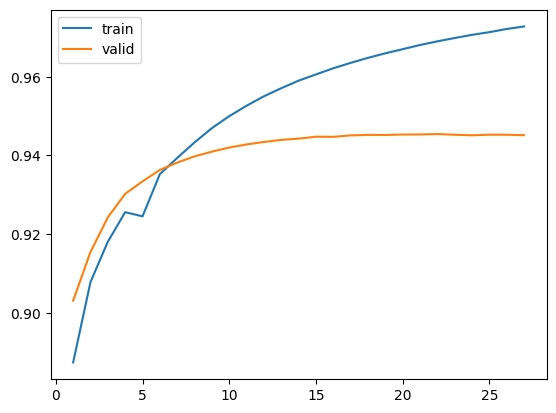

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [28]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [17]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [18]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [20]:
input_test = "She was sick"
print('Input:', input_test)

# Convertir a secuencia
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids:", integer_seq_test)

if len(integer_seq_test) == 0:
    print("⚠️ ERROR: La palabra no está en el vocabulario del tokenizador (input_tokenizer).")
else:
    # Padding
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)

    # Inferencia
    # Asegúrate de haber corrido la celda de 'translate_sentence'
    # y la celda de definición de encoder_model/decoder_model de arriba.
    translation = translate_sentence(encoder_sequence_test)
    print('Response:', translation)

Input: She was sick
Representacion en vector de tokens de ids: [20, 13, 437]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  20  13 437]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Response: ella estaba enferma


In [21]:
input_test = "The cat is under the table"
print('Input:', input_test)

# Convertir a secuencia
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids:", integer_seq_test)

if len(integer_seq_test) == 0:
    print("⚠️ ERROR: La palabra no está en el vocabulario del tokenizador (input_tokenizer).")
else:
    # Padding
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)

    # Inferencia
    # Asegúrate de haber corrido la celda de 'translate_sentence'
    # y la celda de definición de encoder_model/decoder_model de arriba.
    translation = translate_sentence(encoder_sequence_test)
    print('Response:', translation)

Input: The cat is under the table
Representacion en vector de tokens de ids: [1, 366, 7, 426, 1, 389]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1 366   7 426   1 389]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Response: el gato está bajo la mesa


In [23]:
input_test = "This morning I ate an orange"
print('Input:', input_test)

# Convertir a secuencia
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids:", integer_seq_test)

if len(integer_seq_test) == 0:
    print("⚠️ ERROR: La palabra no está en el vocabulario del tokenizador (input_tokenizer).")
else:
    # Padding
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)

    # Inferencia
    # Asegúrate de haber corrido la celda de 'translate_sentence'
    # y la celda de definición de encoder_model/decoder_model de arriba.
    translation = translate_sentence(encoder_sequence_test)
    print('Response:', translation)

Input: This morning I ate an orange
Representacion en vector de tokens de ids: [16, 215, 2, 400, 65, 1695]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0   16
   215    2  400   65 1695]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Response: esta mañana me di una comí


In [24]:
input_test = "life is like a box of chocolates"
print('Input:', input_test)

# Convertir a secuencia
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids:", integer_seq_test)

if len(integer_seq_test) == 0:
    print("⚠️ ERROR: La palabra no está en el vocabulario del tokenizador (input_tokenizer).")
else:
    # Padding
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)

    # Inferencia
    # Asegúrate de haber corrido la celda de 'translate_sentence'
    # y la celda de definición de encoder_model/decoder_model de arriba.
    translation = translate_sentence(encoder_sequence_test)
    print('Response:', translation)

Input: life is like a box of chocolates
Representacion en vector de tokens de ids: [206, 7, 35, 6, 540, 10, 4403]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  206    7
    35    6  540   10 4403]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Response: la vida es como una caja de jabón


In [26]:
input_test = "How much is too much?"
print('Input:', input_test)

# Convertir a secuencia
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids:", integer_seq_test)

if len(integer_seq_test) == 0:
    print("⚠️ ERROR: La palabra no está en el vocabulario del tokenizador (input_tokenizer).")
else:
    # Padding
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    print("Padding del vector:", encoder_sequence_test)

    # Inferencia
    # Asegúrate de haber corrido la celda de 'translate_sentence'
    # y la celda de definición de encoder_model/decoder_model de arriba.
    translation = translate_sentence(encoder_sequence_test)
    print('Response:', translation)

Input: How much is too much?
Representacion en vector de tokens de ids: [47, 101, 7, 95, 101]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  47 101   7  95 101]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Response: cuánto es demasiado
